In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, utils
import tensorflow as tf

In [ ]:
#colab drive 연결

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/peak_classification/workout/'

# Initialize lists for data and labels
data = []
labels = []

# Load data from all subdirectories
for root, dirs, files in os.walk(data_dir):
    for filename in files:
        if filename.endswith('.csv'):
            filepath = os.path.join(root, filename)
            df = pd.read_csv(filepath)
            label = df['Label'].iloc[0]  # Assume label is consistent within a window
            df = df.drop(columns=['Label'])
            data.append(df.values)
            labels.append(label)

# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Print shapes
print('Data shape:', data.shape)     # (num_samples, window_size, num_features)
print('Labels shape:', labels.shape)

Data shape: (5575, 52, 12)
Labels shape: (5575,)


In [ ]:
# Split into training and testing sets
X_temp, X_test, y_temp, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels)

validation_size = 0.1111  # Validation should be ~10% of original data
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=validation_size, random_state=42, stratify=y_temp
)

print('Training data shape:', X_train.shape)
print('Testing data shape:', X_test.shape)

Training data shape: (3964, 52, 12)
Testing data shape: (1115, 52, 12)


In [ ]:
num_samples, window_size, num_features = X_train.shape

In [ ]:

def build_tcn_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = inputs
    # 여기 !!!!!!!!!!!!!!!!!!!!!!
    num_filters = 16
    kernel_size = 3
    num_levels = 2  # Number of residual blocks

    for i in range(num_levels):
        dilation_rate = 2 ** i
        x_prev = x
        # First Conv1D layer
        x = layers.Conv1D(filters=num_filters, kernel_size=kernel_size,
                          padding='causal', dilation_rate=dilation_rate)(x)
        x = layers.LayerNormalization()(x)
        x = layers.ReLU()(x)
        # Second Conv1D layer
        x = layers.Conv1D(filters=num_filters, kernel_size=kernel_size,
                          padding='causal', dilation_rate=dilation_rate)(x)
        x = layers.LayerNormalization()(x)
        x = layers.ReLU()(x)
        # Residual connection
        if x_prev.shape[-1] != num_filters:
            x_prev = layers.Conv1D(filters=num_filters, kernel_size=1, padding='same')(x_prev)
        x = layers.add([x, x_prev])

    # Global average pooling and output layer
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
num_classes = 2

y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes) # Also one-hot encode for consistency

In [ ]:
# Build the model





input_shape = X_train.shape[1:]  # (max_sequence_length, num_features)
model = build_tcn_model(input_shape, num_classes)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Define early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_loss',
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 52, 12)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 52, 16)         │            592 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 52, 16)         │             32 │ conv1d[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 52, 16)         │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 52, 16)         │            784 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 52, 16)         │             32 │ conv1d_1[0][0]         │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 52, 16)         │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 52, 16)         │            208 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 52, 16)         │              0 │ re_lu_1[0][0],         │
│                           │                        │                │ conv1d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 52, 16)         │            784 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 52, 16)         │             32 │ conv1d_3[0][0]         │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 52, 16)         │              0 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 52, 16)         │            784 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 52, 16)         │             32 │ conv1d_4[0][0]         │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 52, 16)         │              0 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 52, 16)         │              0 │ re_lu_3[0][0],         │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_poolin

 Total params: 3,314 (12.95 KB)

 Trainable params: 3,314 (12.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.4432 - loss: 8.7782 - val_accuracy: 0.7036 - val_loss: 0.5858
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7197 - loss: 0.5733 - val_accuracy: 0.7681 - val_loss: 0.4700
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7860 - loss: 0.4773 - val_accuracy: 0.7702 - val_loss: 0.4606
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7931 - loss: 0.4605 - val_accuracy: 0.7964 - val_loss: 0.4416
Epoch 5/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8041 - loss: 0.4417 - val_accuracy: 0.8044 - val_loss: 0.4244
Epoch 6/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8052 - loss: 0.4278 - val_accuracy: 0.8226 - val_loss: 0.4172
Epoch 7/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8120 - loss: 0.4181 - val_accuracy: 0.8165 - val_loss: 0.4312
Epoch 8/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7991 - loss: 0.4336 - val_a

In [ ]:
y_train[0]

array([1., 0.])

In [ ]:
# Evaluate on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8644 - loss: 0.3401
Test Accuracy: 86.91%


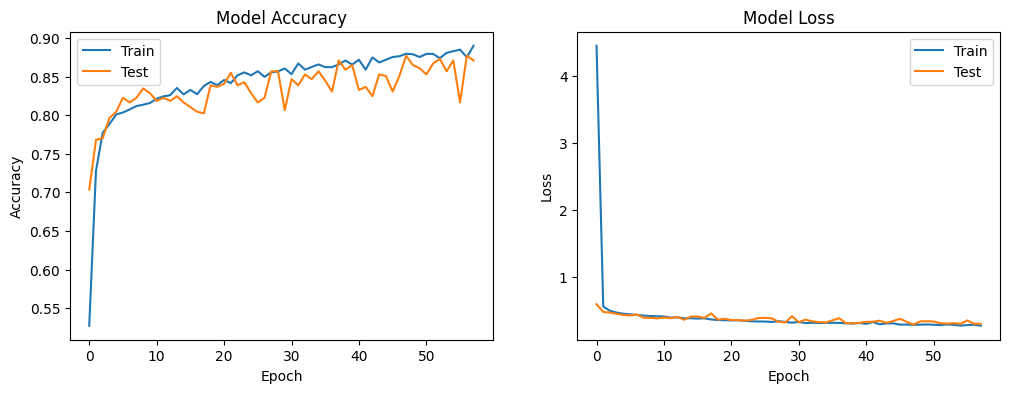

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# Predict probabilities
y_pred_prob = model.predict(X_test)
# Convert probabilities to class labels
y_pred = (y_pred_prob > 0.5).astype('int32').flatten()

# Display some predictions
for i in range(10):
    print(f'Actual: {y_test[i].argmax()}, Predicted: {y_pred[i]}')


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Actual: 0, Predicted: 1
Actual: 0, Predicted: 0
Actual: 0, Predicted: 1
Actual: 1, Predicted: 0
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 0, Predicted: 1
Actual: 1, Predicted: 0
Actual: 1, Predicted: 0
Actual: 1, Predicted: 1


In [ ]:
# Save the model
model_save_path = '/content/drive/MyDrive/TCN_Trained_Model_Data/peak_count_model_no nonworkout_lev_num2_1220.h5'
model.save(model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to /content/drive/MyDrive/TCN_Trained_Model_Data/peak_count_model_no nonworkout_lev_num2_1220.h5


In [ ]:
# Predict probabilities, ensuring X_test has the correct shape for prediction
# Assuming your model expects a 3D input
y_pred_prob = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Convert probabilities to class labels
# Modified to handle multilabel output
y_pred = (y_pred_prob > 0.5).astype('int32')  # Remove flatten()

# No need to trim y_pred if the shapes are already compatible

from sklearn.metrics import classification_report, confusion_matrix

print('Classification Report:')
# Use argmax to convert y_test to multiclass if necessary
# Check if y_test is multilabel-indicator (has multiple 1s per row)
if y_test.ndim == 2 and y_test.shape[1] > 1 and any(y_test.sum(axis=1) > 1):
    # If multilabel-indicator, use classification_report for multilabel
    from sklearn.metrics import multilabel_confusion_matrix
    print(classification_report(y_test, y_pred, target_names=['class_0', 'class_1']))  # Assuming two classes
    print('Multilabel Confusion Matrix:')
    print(multilabel_confusion_matrix(y_test, y_pred))
else:
    # If not multilabel-indicator, convert to single-digit ones using argmax
    y_test_arg = np.argmax(y_test, axis=1)
    y_pred_arg = np.argmax(y_pred, axis=1)  # Get the predicted class index
    print(classification_report(y_test_arg, y_pred_arg))

    print('Confusion Matrix:')
    print(confusion_matrix(y_test_arg, y_pred_arg))

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       710
           1       0.85      0.78      0.81       405

    accuracy                           0.87      1115
   macro avg       0.86      0.85      0.86      1115
weighted avg       0.87      0.87      0.87      1115

Confusion Matrix:
[[652  58]
 [ 88 317]]
